In [15]:
# Import necessary libraries and dependencies
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
import re
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_predict
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, precision_score, recall_score, roc_curve



import nltk
nltk.download('stopwords')


#Phase 1 : Data Preparation and Preprocessing

# Set up configurations for plotting and visualization
sns.set(style="whitegrid")
%matplotlib inline

# Load the dataset
data = pd.read_csv('C:\\Users\\Admin\\Desktop\\Project\\Tweets.csv')
data.head(-5)



[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14630,569588473050611712,positive,1.0000,NaN,NaN,American,NaN,Laurelinesblog,NaN,0,@AmericanAir Thanks! He is.,NaN,2015-02-22 12:04:09 -0800,"Chapel Hill, NC",NaN
14631,569588464896876545,negative,1.0000,Bad Flight,1.0000,American,NaN,MDDavis7,NaN,0,@AmericanAir thx for nothing on getting us out...,NaN,2015-02-22 12:04:07 -0800,US,Eastern Time (US & Canada)
14632,569587813856841728,neutral,0.6760,NaN,0.0000,American,NaN,Chad_SMFYM,NaN,0,"“@AmericanAir: @TilleyMonsta George, that does...",NaN,2015-02-22 12:01:31 -0800,NaN,Central Time (US & Canada)
14633,569587705937600512,negative,1.0000,Cancelled Flight,1.0000,American,NaN,RussellsWriting,NaN,0,@AmericanAir my flight was Cancelled Flightled...,NaN,2015-02-22 12:01:06 -0800,Los Angeles,Arizona


In [16]:
# Clean the dataset by removing rows with low confidence levels
data = data[data['airline_sentiment_confidence'] > 0.65].copy()

# Create a new column 'sentiment'
data['sentiment'] = np.where(data['airline_sentiment'] == 'negative', 1, 0)

# Apply text cleaning using BeautifulSoup
def clean_text(text):
    # Remove HTML tags
    text = BeautifulSoup(text, "html.parser").get_text()
    # Remove special characters and digits
    text = re.sub(r'[^a-zA-Z]', ' ', text)
    # Convert to lowercase and split into words
    words = text.lower().split()
    # Remove stop words and perform stemming
    stop_words = set(stopwords.words("english"))
    ps = PorterStemmer()
    words = [ps.stem(word) for word in words if word not in stop_words]
    # Join the words back into a string
    return ' '.join(words)

# Apply text cleaning to the 'text' column
data['text_clean'] = data['text'].apply(clean_text)

# Retain relevant columns
data = data[['text_clean', 'sentiment']]

# Display the first few rows of the cleaned dataset
data.head(-5)






C:\Users\Admin\AppData\Local\Temp\ipykernel_6664\3965908976.py:10: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, "html.parser").get_text()


,text_clean,sentiment
0,virginamerica dhepburn said,0
2,virginamerica today must mean need take anoth ...,0
3,virginamerica realli aggress blast obnoxi ente...,1
4,virginamerica realli big bad thing,1
5,virginamerica serious would pay flight seat pl...,1
...,...,...
14629,americanair chang flight phone system keep tel...,1
14630,americanair thank,0
14631,americanair thx noth get us countri back us br...,1
14632,americanair tilleymonsta georg look good pleas...,0


C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


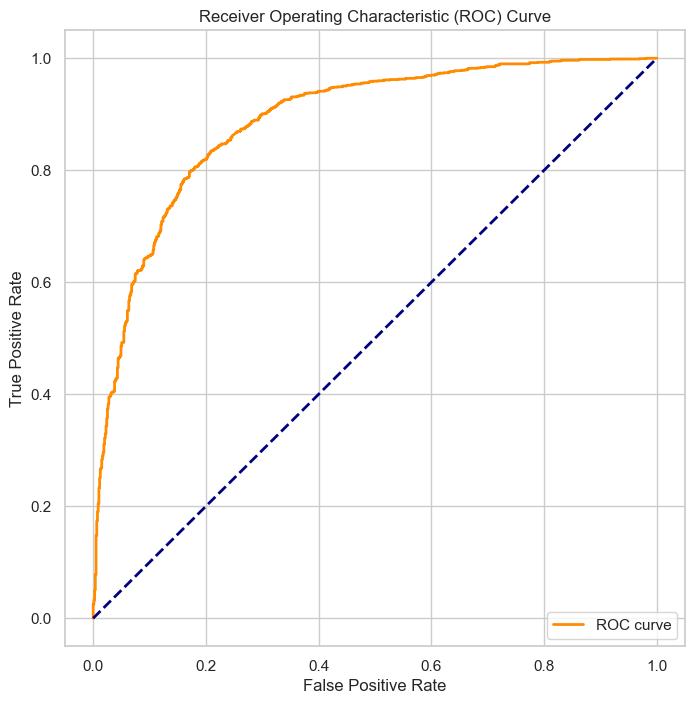

Predicted Sentiment: [0]


In [18]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    data['text_clean'],
    data['sentiment'],
    test_size=0.2,
    random_state=1
)

# Define tokenization and stemming functions
def tokenize(text):
    return text.split()

# Create English stopwords using NLTK
stop_words = list(stopwords.words('english'))

# Initialize CountVectorizer
vectorizer = CountVectorizer(
    analyzer='word',
    tokenizer=tokenize,
    lowercase=True,
    ngram_range=(1, 1),
    stop_words=stop_words
)

# Implement StratifiedKFold cross-validation with 5 splits
kf = StratifiedKFold(n_splits=5, random_state=1, shuffle=True)

# Build a pipeline for SVM classification
clf = make_pipeline(vectorizer, SVC(probability=True, kernel='linear', class_weight='balanced', random_state=1))

# Implement the report_results function
def report_results(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    print(f"AUC: {auc(fpr, tpr)}")
    print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
    print(f"F1 Score: {f1_score(y_test, y_pred)}")
    print(f"Precision: {precision_score(y_test, y_pred)}")
    print(f"Recall: {recall_score(y_test, y_pred)}")

# Implement the get_roc_curve function
def get_roc_curve(model, X_test, y_test):
    y_prob = model.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, y_prob)
    return fpr, tpr

# Train and evaluate the model using cross-validation
for train_index, test_index in kf.split(X_train, y_train):
    X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[test_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[test_index]

    clf.fit(X_train_fold, y_train_fold)
    fpr, tpr = get_roc_curve(clf, X_val_fold, y_val_fold)

# Plot the ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Display ROC curve plot
plt.show()

# Use the best estimator to predict the sentiment of a sample tweet
sample_tweet = ["This airline is terrible! The service is awful."]
predicted_sentiment = clf.predict(sample_tweet)
print(f"Predicted Sentiment: {predicted_sentiment}")
